In [3]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2
import pandas as pd
from svgpathtools import parse_path
import svg_distance_helpers as rsh

#### directory and file hierarchy

In [4]:
# directory & file hierarchy
analysis_dir = os.getcwd()
tracing_ref_pixel = os.path.join(analysis_dir, 'tracing_ref_pixel')
tracing_ref_svg = os.path.join(analysis_dir, 'tracing_ref_svg')

canvas_side = 819

In [5]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

#### fetch an example tracing

In [6]:
imrecs = coll.find({'$and':[{'category':'square'},{'dataType':'finalImage'}, {'sessionId':'cdm_run_v31525894399483'}]}).sort('time')
print imrecs.count()

## retrieve example square tracing from db
imrec = imrecs[0] 

1


In [7]:
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## get verts and codes in all strokes
        ## both verts_list and codes_list are 2D list. Each sublist represent a stroke
        verts_list, codes_list = rsh.get_stroke_verts_and_codes(svg_list)
        
        ## Convert multiple strokes into one stroke
        
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

Number of strokes in this tracing: 3


#### preprocessing of tracing and visualization (if desired)


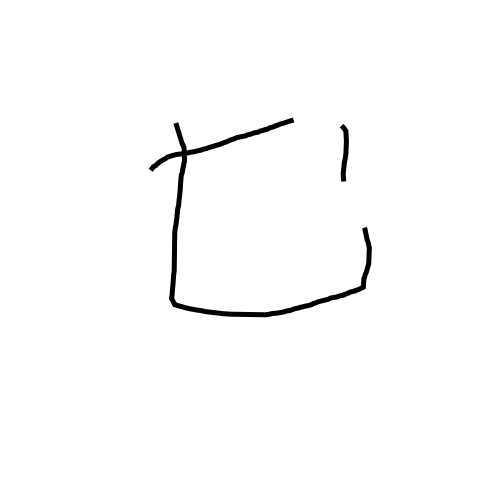

In [64]:
reallyRun = 1
if reallyRun:
    rsh.plot_shape(verts_list,codes_list, canvas_side)
    

#### Get the reference shape and adjust it based on the canvas size

In [27]:
## get vertices and codes for reference shape (in this example, a square)
reload(rsh)
square_file = os.path.join(tracing_ref_pixel, 'resize_square.png')
ref_verts, ref_codes = rsh.get_ref_square(square_file, canvas_side)
print ref_verts

[[234, 234], [584, 234], [584, 584], [234, 584], [234, 234]]


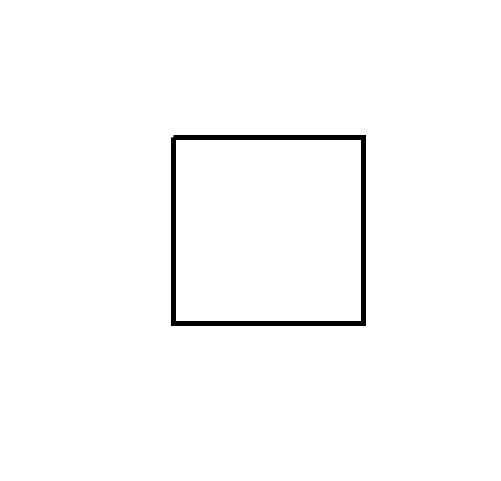

In [28]:
## examine reference shape (in this example, a square)
reallyRun = 1
if reallyRun:
    rsh.plot_stroke(ref_verts,ref_codes, canvas_side)

#### Try different transformation on each stroke

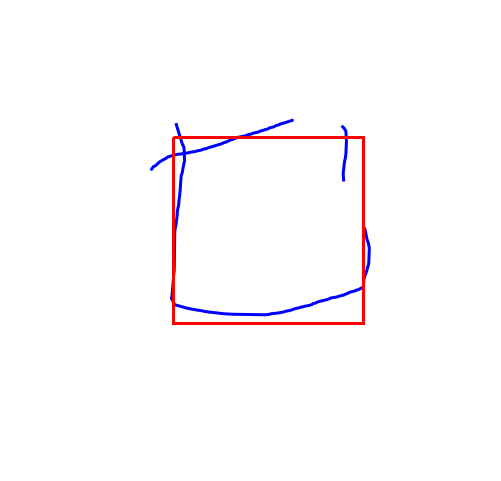

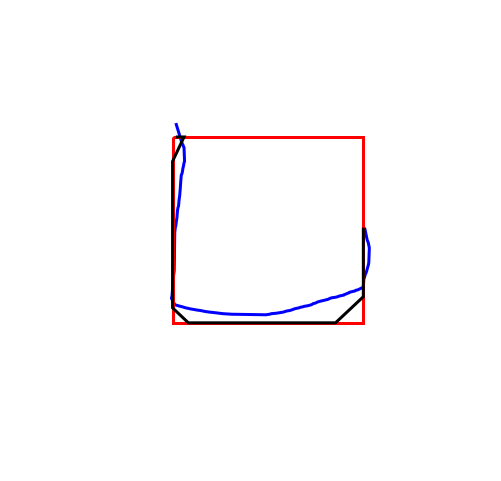

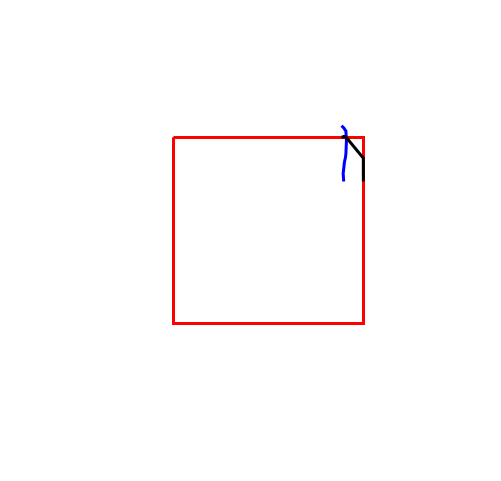

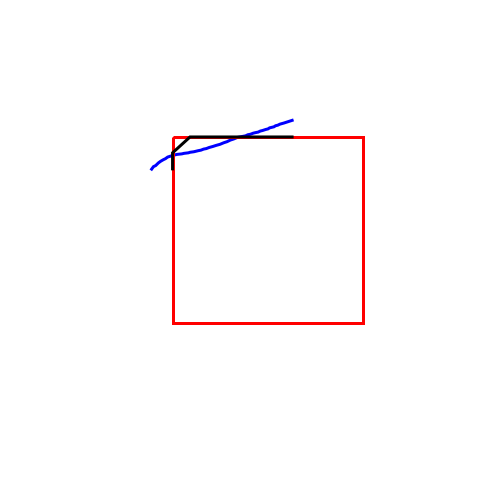

In [89]:
reload(rsh)
rsh.plot_stroke_coregistered_shapes(verts_list, ref_verts,canvas_side)
for stroke in verts_list:
    cor_verts = rsh.get_corresponding_verts(np.array(stroke), np.array(ref_verts))
    rsh.plot_stroke_corresponding_points_on_reference(stroke,ref_verts,cor_verts,canvas_side)

In [84]:
reload(rsh)
tra_verts_list = []
total_err = 0

for verts in verts_list:
    min_err, tra_verts = rsh.min_single_stroke_err(verts, ref_verts)
    total_err += min_err
    tra_verts_list.append(tra_verts)

x_data size torch.Size([109, 2])
y_data size torch.Size([109, 2])
1e-09
weight tensor([[1., 0.],
        [0., 1.]])
epoch 0, loss 28986.2207031
epoch 100, loss 21305.2929688
epoch 200, loss 21138.5644531
epoch 300, loss 21006.171875
epoch 400, loss 20900.5507812
epoch 500, loss 20816.3085938
epoch 600, loss 20749.1230469
epoch 700, loss 20695.5214844
epoch 800, loss 20652.7382812
epoch 900, loss 20618.6269531
x_data size torch.Size([13, 2])
y_data size torch.Size([13, 2])
1e-09
weight tensor([[1., 0.],
        [0., 1.]])
epoch 0, loss 5034.77294922
epoch 100, loss 3877.06640625
epoch 200, loss 3429.28686523
epoch 300, loss 3253.99560547
epoch 400, loss 3183.35083008
epoch 500, loss 3152.89208984
epoch 600, loss 3137.8894043
epoch 700, loss 3128.84179688
epoch 800, loss 3122.09716797
epoch 900, loss 3116.25024414
x_data size torch.Size([48, 2])
y_data size torch.Size([48, 2])
1e-09
weight tensor([[1., 0.],
        [0., 1.]])
epoch 0, loss 9080.27148438
epoch 100, loss 8891.99023438
epoc

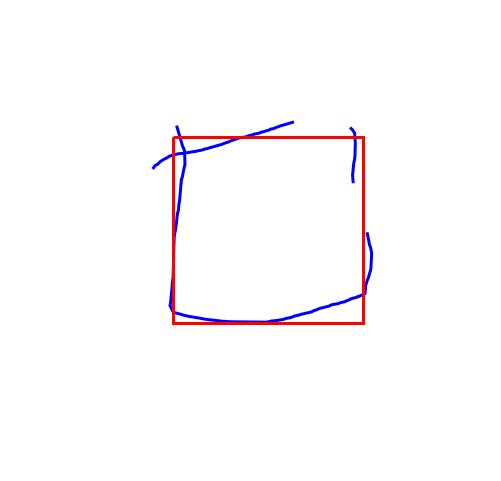

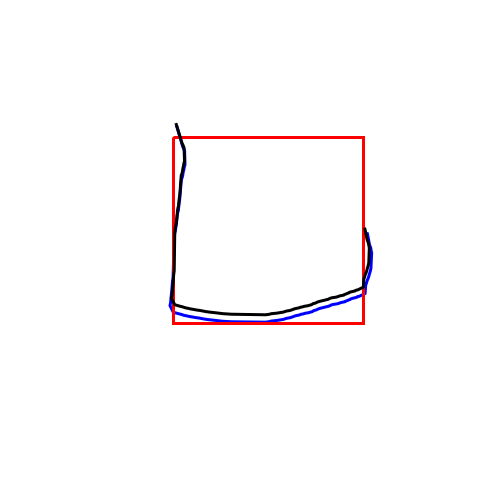

ValueError: 'codes' must be a 1D list or array with the same length of 'vertices'

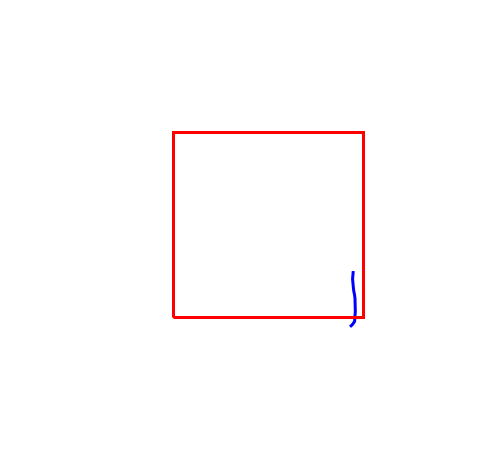

In [91]:
reload(rsh)
rsh.plot_stroke_coregistered_shapes(tra_verts_list, ref_verts,canvas_side)
for stroke in tra_verts_list:
    cor_verts = rsh.get_corresponding_verts(np.array(stroke), np.array(ref_verts))
    rsh.plot_stroke_corresponding_points_on_reference(stroke,ref_verts,verts_list[0],canvas_side)

##### test case for particular line segment AB on reference shape and point P on tracing (optional, sanity checks)

In [ ]:
run_tests = 0
if run_tests:
    ## toy case
    A = np.array((0,0))
    B = np.array((10,10))
    P = np.array((20,5)) ## first point

    ## get point C on A,B that minimizes distance from particular point on tracing to the line segment AB
    C = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False) 
    
    ## example real case
    a = ref_verts[0]
    b = ref_verts[1]
    p = tra_verts[1]
    c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
    print c,d    

#### get "corresponding points" on the reference shape for each vertex in the tracing

In [ ]:
## cor_verts will be the same shape as the tra_verts, and lie on the reference shape
## error will be computed as area between these two shapes
cor_verts = np.zeros((np.shape(tra_verts)[0],2))
for i,t in enumerate(tra_verts): ## loop through segments of the tracing
    p = t ## endpoint of the current tracing segment
    ## for a given point on the tracing, find the corresponding closest point on the reference shape
    ref_gen = rsh.pairs(ref_verts)
    D = 1e6 ## initialize at some crazy large value
    for r in ref_gen:
        a = r[0]
        b = r[1]
        c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
        if d<D: ## if the shortest distance so far, then swap in for the value of D
            D = d
            C = c
        else:
            pass 
    cor_verts[i,:] = C ## assign the closest corresponding point to the "corresponding vertices" array

In [ ]:
## test to make sure the corresponding points really lie on the reference shape
reload(rsh)
reallyRun = 1
if reallyRun:
    rsh.plot_corresponding_points_on_reference(tra_verts,tra_codes,ref_verts,ref_codes,cor_verts)

#### actually get svg distance error now

In [ ]:
## iterate through each pair of line segments comprising the tracing verts
## and corresponding verts, and increment error as area between the line
## segments. 
## When line segments are non-intersecting and non-collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments are parallel but not collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments intersect, then add the resulting triangles
## formed by the intersecting segments
## If line segments are collinear, do not increment error, b/c perfectly on the line
tracing_to_corresponding_error = rsh.get_area_between_tracing_and_corresponding_verts(tra_verts,cor_verts)

## add to the above the deviation between the area of the reference
## shape and the corresponding shape
cor_area = rsh.get_area_polygon(cor_verts)
ref_area = rsh.get_area_polygon(ref_verts)
corresponding_to_reference_error = abs(abs(ref_area)-abs(cor_area))

In [ ]:
## total error is sum of tracing_to_corresponding_error and corresponding_to_reference_error
total_error = tracing_to_corresponding_error + tracing_to_corresponding_error

svg_distance_score = np.sqrt(total_error)
print 'SVG distance score = {}'.format(svg_distance_score)